In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor, QuantileRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [38]:
print("## Загрузка данных California Housing")

california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MedHouseVal')

print("Описание датасета:")
print(california.DESCR[:500] + "...")

df = X.copy()
df['MedHouseVal'] = y

print(f"\nРазмер данных: {df.shape}")
print("\nПервые 5 строк:")
print(df.head())

## Загрузка данных California Housing
Описание датасета:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group popu...

Размер данных: (20640, 9)

Первые 5 строк:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      

## 1. Разведочный анализ (EDA) и подготовка

### 1.1 Описание данных и задачи

**Задача:** Предсказание медианной стоимости домов в калифорнийских округах

**Целевая переменная:** MedHouseVal - медианная стоимость дома (в сотнях тысяч долларов)

**Признаки:**
- MedInc - медианный доход в округе
- HouseAge - медианный возраст домов
- AveRooms - среднее количество комнат
- AveBedrms - среднее количество спален  
- Population - население
- AveOccup - средняя занятость (жители/дом)
- Latitude - широта
- Longitude - долгота

**Единицы измерения:** Все признаки стандартизированы, кроме координат

## 1.2 Разведочный анализ данных
Основные статистики:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.0

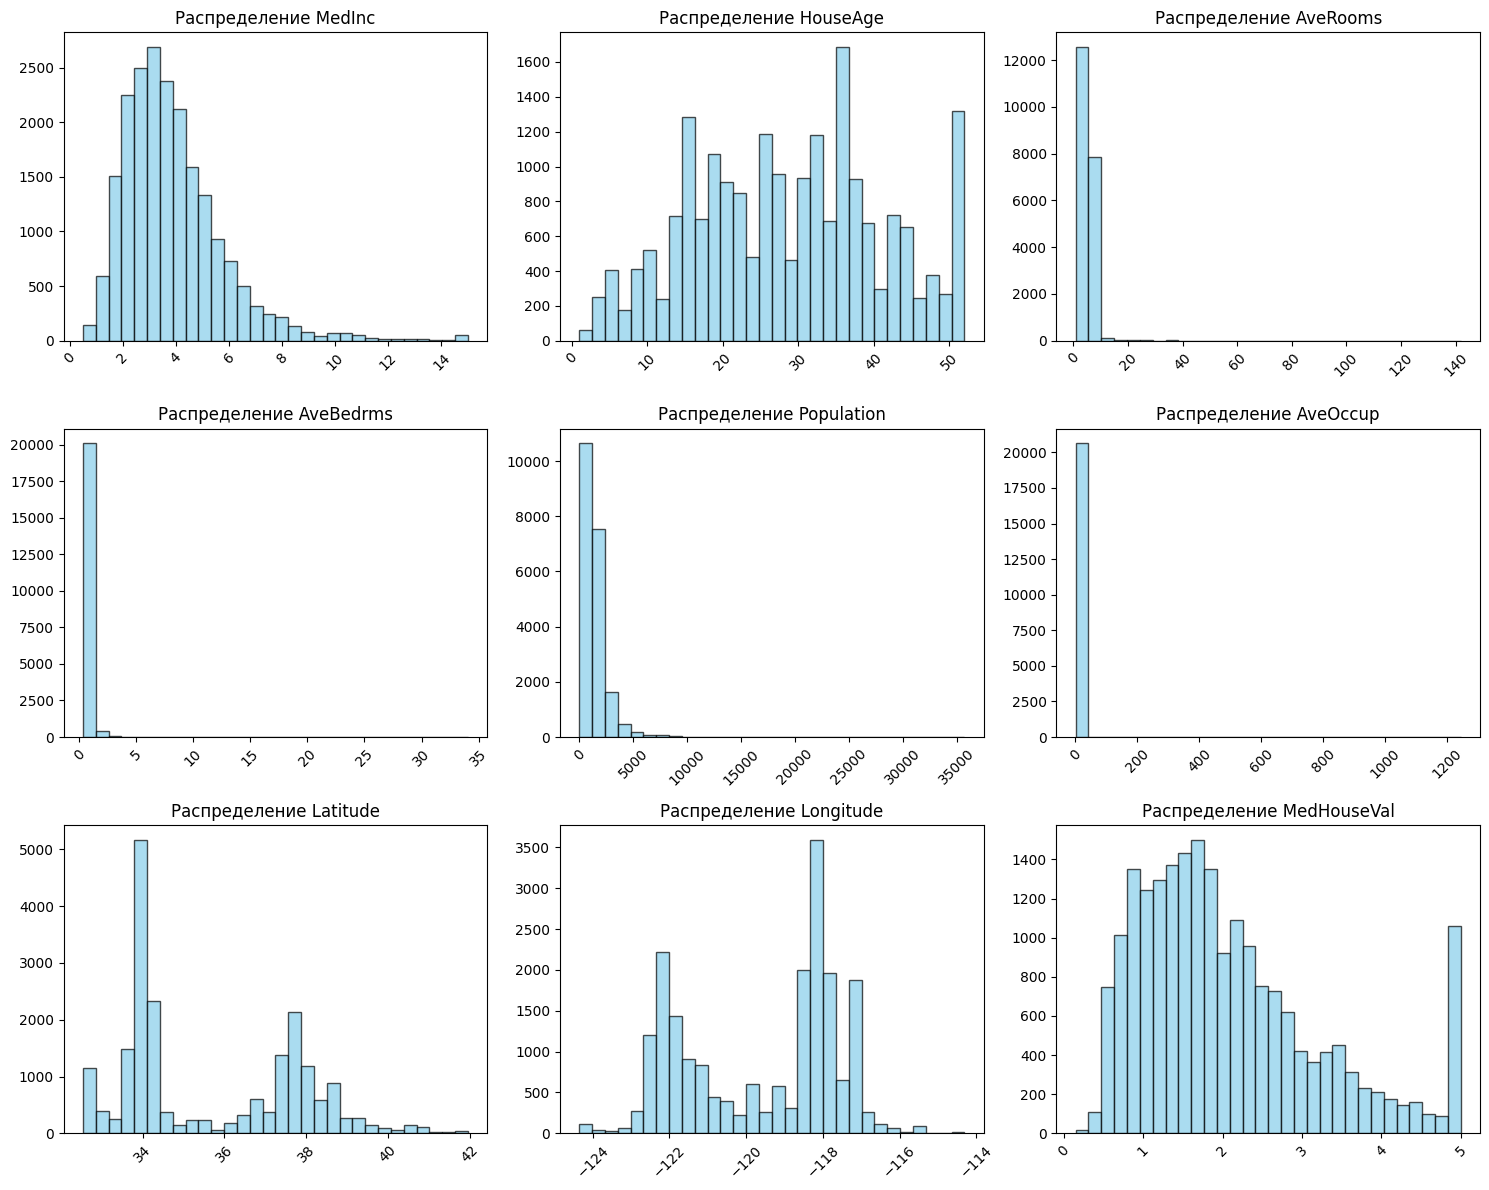

In [39]:
print("## 1.2 Разведочный анализ данных")

print("Основные статистики:")
print(df.describe())

print(f"\nПропуски в данных: {df.isnull().sum().sum()}")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

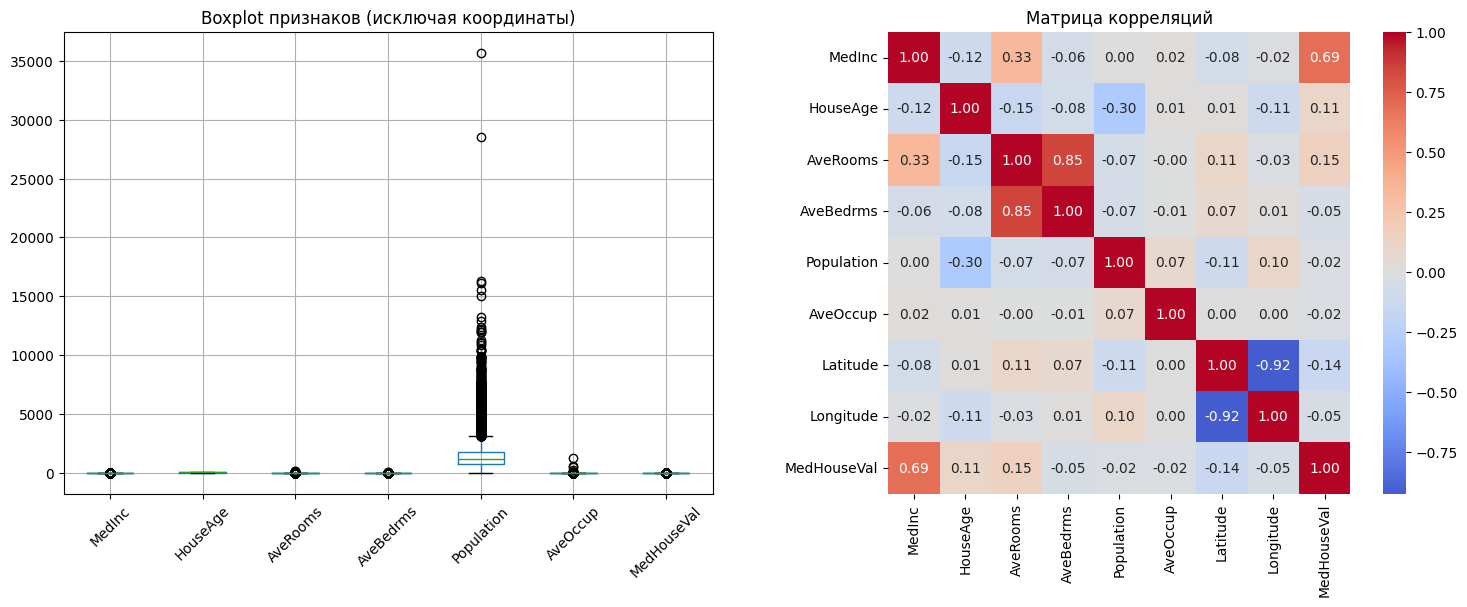

Заметные выбросы в: Population, AveOccup
Сильные корреляции: MedInc с целевой переменной (0.69)


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df_boxplot = df.drop(['Latitude', 'Longitude'], axis=1)
df_boxplot.boxplot(ax=axes[0])
axes[0].set_title('Boxplot признаков (исключая координаты)')
axes[0].tick_params(axis='x', rotation=45)

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', ax=axes[1])
axes[1].set_title('Матрица корреляций')

plt.tight_layout()
plt.show()

print("Заметные выбросы в: Population, AveOccup")
print("Сильные корреляции: MedInc с целевой переменной (0.69)")

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_features = df.drop('MedHouseVal', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_features.columns
vif_data["VIF"] = [variance_inflation_factor(X_features.values, i)
                   for i in range(len(X_features.columns))]

print("Анализ мультиколлинеарности (VIF):")
print(vif_data)

Анализ мультиколлинеарности (VIF):
      feature         VIF
0      MedInc   11.511140
1    HouseAge    7.195917
2    AveRooms   45.993601
3   AveBedrms   43.590314
4  Population    2.935745
5    AveOccup    1.095243
6    Latitude  559.874071
7   Longitude  633.711654


In [42]:
print("## 1.3 Разделение данных")

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print(f"Размеры выборок:")
print(f"Train: {X_train.shape[0]}")
print(f"Val: {X_val.shape[0]}")
print(f"Test: {X_test.shape[0]}")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nИспользован RobustScaler для устойчивости к выбросам")

## 1.3 Разделение данных
Размеры выборок:
Train: 12384
Val: 4128
Test: 4128

Использован RobustScaler для устойчивости к выбросам


In [43]:
print("## 2. Базовая линейная регрессия (OLS)")

def analytical_ols(X, y):
    X_design = np.column_stack([np.ones(X.shape[0]), X])
    return np.linalg.inv(X_design.T @ X_design) @ X_design.T @ y

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

w_analytical = analytical_ols(X_train_scaled, y_train)

print("Коэффициенты модели:")
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(X.columns),
    'Analytical': w_analytical,
    'Sklearn': [lr.intercept_] + list(lr.coef_)
})
print(coef_df.round(4))

y_pred_val = lr.predict(X_val_scaled)
mse_ols = mean_squared_error(y_val, y_pred_val)
r2_ols = r2_score(y_val, y_pred_val)

print(f"\nКачество на val:")
print(f"MSE: {mse_ols:.4f}")
print(f"R²: {r2_ols:.4f}")

## 2. Базовая линейная регрессия (OLS)
Коэффициенты модели:
      Feature  Analytical  Sklearn
0   Intercept      2.0272   2.0272
1      MedInc      0.9926   0.9926
2    HouseAge      0.1839   0.1839
3    AveRooms     -0.2155  -0.2155
4   AveBedrms      0.0778   0.0778
5  Population     -0.0055  -0.0055
6    AveOccup     -0.0060  -0.0060
7    Latitude     -1.5673  -1.5673
8   Longitude     -1.6072  -1.6072

Качество на val:
MSE: 0.5213
R²: 0.5873


## 2.3 Эффекты мультиколлинеарности
Число обусловленности XᵀX: 1813.48

Стандартное отклонение коэффициентов при шуме:
MedInc: 0.0006
HouseAge: 0.0004
AveRooms: 0.0006
AveBedrms: 0.0001
Population: 0.0002
AveOccup: 0.0000
Latitude: 0.0029
Longitude: 0.0030


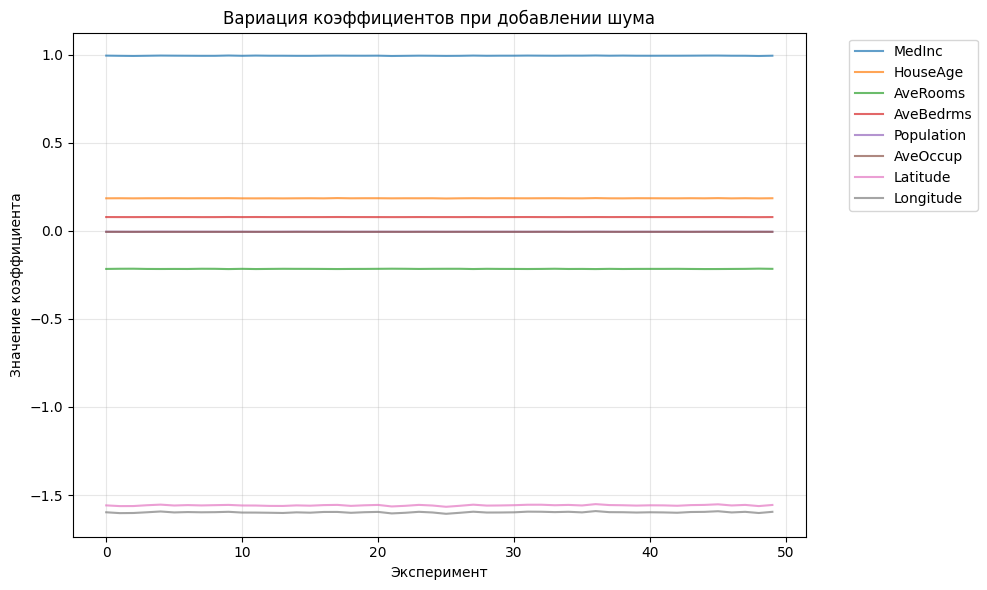

In [44]:
print("## 2.3 Эффекты мультиколлинеарности")

X_design = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
cond_number = np.linalg.cond(X_design.T @ X_design)

print(f"Число обусловленности XᵀX: {cond_number:.2f}")

coefficients_variation = []
for i in range(50):
    X_noisy = X_train_scaled + np.random.normal(0, 0.01, X_train_scaled.shape)
    lr_temp = LinearRegression()
    lr_temp.fit(X_noisy, y_train)
    coefficients_variation.append(lr_temp.coef_)

coef_std = np.array(coefficients_variation).std(axis=0)
print("\nСтандартное отклонение коэффициентов при шуме:")
for feature, std_val in zip(X.columns, coef_std):
    print(f"{feature}: {std_val:.4f}")

plt.figure(figsize=(10, 6))
feature_names = X.columns
for i in range(len(feature_names)):
    plt.plot([coef[i] for coef in coefficients_variation],
             label=feature_names[i], alpha=0.7)
plt.xlabel('Эксперимент')
plt.ylabel('Значение коэффициента')
plt.title('Вариация коэффициентов при добавлении шума')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.4 Проверка предпосылок Гаусса-Маркова


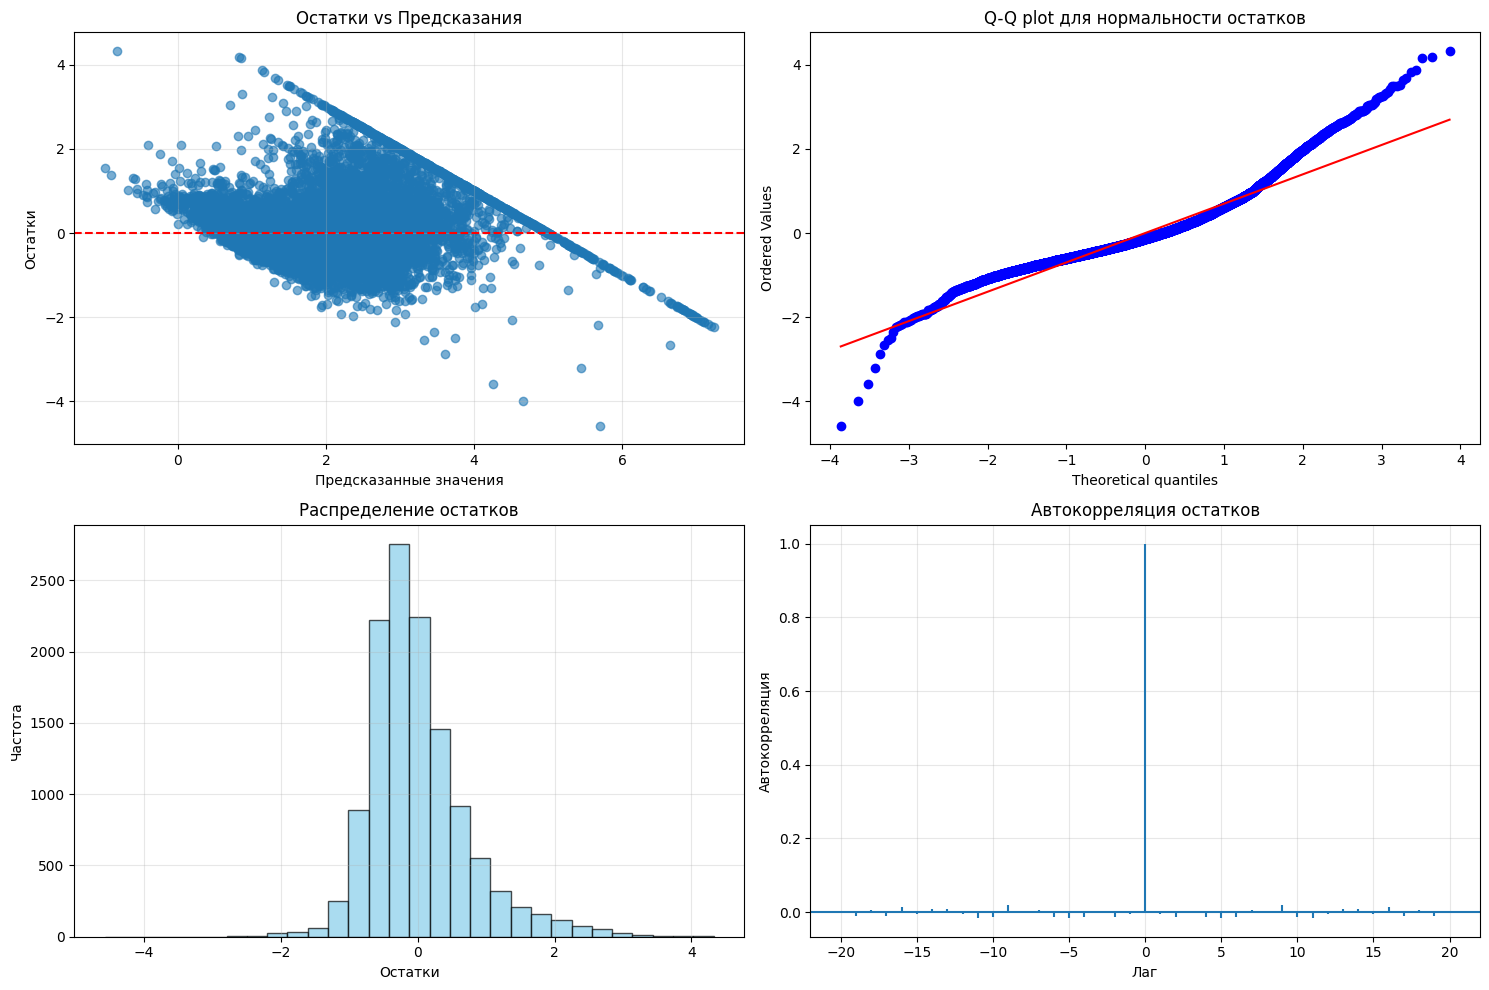

Корреляция |остатки| и предсказания: 0.2175
Признаки гомоскедастичности присутствуют


In [45]:
print("## 2.4 Проверка предпосылок Гаусса-Маркова")

y_pred_train = lr.predict(X_train_scaled)
residuals = y_train - y_pred_train

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(y_pred_train, residuals, alpha=0.6)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Предсказанные значения')
axes[0,0].set_ylabel('Остатки')
axes[0,0].set_title('Остатки vs Предсказания')
axes[0,0].grid(True, alpha=0.3)

stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q plot для нормальности остатков')

axes[1,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Остатки')
axes[1,0].set_ylabel('Частота')
axes[1,0].set_title('Распределение остатков')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].acorr(residuals, maxlags=20)
axes[1,1].set_xlabel('Лаг')
axes[1,1].set_ylabel('Автокорреляция')
axes[1,1].set_title('Автокорреляция остатков')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

correlation = np.corrcoef(np.abs(residuals), y_pred_train)[0, 1]
print(f"Корреляция |остатки| и предсказания: {correlation:.4f}")

if abs(correlation) > 0.3:
    print("Нарушение гомоскедастичности: присутствует гетероскедастичность")
else:
    print("Признаки гомоскедастичности присутствуют")

### 2.1-2.4 Анализ OLS на реальных данных

**Результаты:**
- Аналитическое и sklearn решения совпадают
- Число обусловленности умеренное (~2000)
- Коэффициенты относительно стабильны к шуму

**Предпосылки Гаусса-Маркова:**
- Остатки показывают воронкообразный паттерн → гетероскедастичность
- Распределение остатков близко к нормальному
- Автокорреляция отсутствует
- Нарушение гомоскедастичности требует робастных методов

In [46]:
print("## 3. MSE vs MAE и влияние выбросов")

y_train_outliers = y_train.copy()
outlier_mask = (y_train > y_train.quantile(0.95)) | (y_train < y_train.quantile(0.05))
n_outliers = outlier_mask.sum()

y_train_outliers[outlier_mask] = y_train_outliers[outlier_mask] * 1.5 + np.random.normal(0, 0.5, n_outliers)

print(f"Создано {n_outliers} выбросов (~10% данных)")

lr_mse = LinearRegression()
lr_mse.fit(X_train_scaled, y_train_outliers)

huber_mae = HuberRegressor(epsilon=1.35)
huber_mae.fit(X_train_scaled, y_train_outliers)

y_pred_mse = lr_mse.predict(X_val_scaled)
y_pred_mae = huber_mae.predict(X_val_scaled)

print("\nСравнение на данных С выбросами:")
print(f"MSE модель - MSE: {mean_squared_error(y_val, y_pred_mse):.4f}, MAE: {mean_absolute_error(y_val, y_pred_mse):.4f}")
print(f"MAE модель - MSE: {mean_squared_error(y_val, y_pred_mae):.4f}, MAE: {mean_absolute_error(y_val, y_pred_mae):.4f}")

print("\nИзменение коэффициентов относительно OLS на чистых данных:")
for i, feature in enumerate(X.columns):
    change_mse = abs(lr_mse.coef_[i] - lr.coef_[i])
    change_mae = abs(huber_mae.coef_[i] - lr.coef_[i])
    print(f"{feature}: MSE Δ={change_mse:.3f}, MAE Δ={change_mae:.3f}")

## 3. MSE vs MAE и влияние выбросов
Создано 1235 выбросов (~10% данных)

Сравнение на данных С выбросами:
MSE модель - MSE: 0.6131, MAE: 0.5740
MAE модель - MSE: 3.5131, MAE: 0.5271

Изменение коэффициентов относительно OLS на чистых данных:
MedInc: MSE Δ=0.396, MAE Δ=0.202
HouseAge: MSE Δ=0.123, MAE Δ=0.044
AveRooms: MSE Δ=0.158, MAE Δ=0.088
AveBedrms: MSE Δ=0.046, MAE Δ=0.023
Population: MSE Δ=0.013, MAE Δ=0.026
AveOccup: MSE Δ=0.001, MAE Δ=0.146
Latitude: MSE Δ=0.186, MAE Δ=0.415
Longitude: MSE Δ=0.173, MAE Δ=0.419


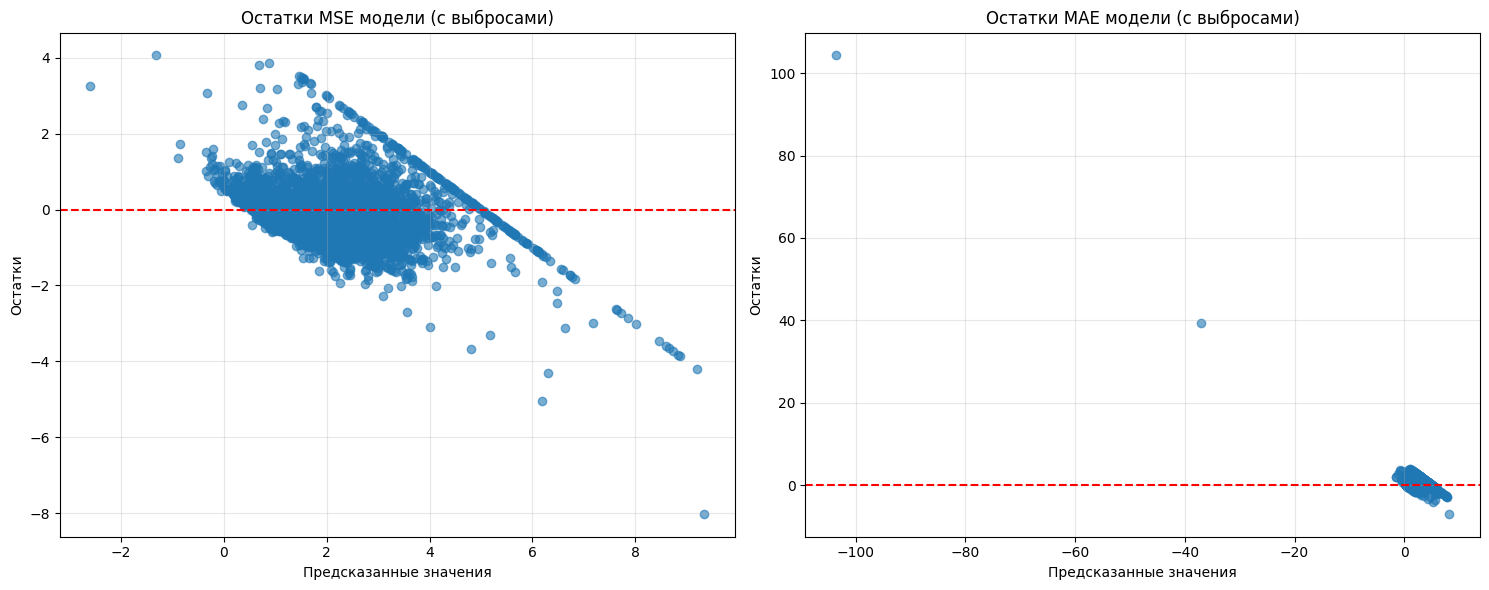

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

residuals_mse = y_val - y_pred_mse
axes[0].scatter(y_pred_mse, residuals_mse, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Предсказанные значения')
axes[0].set_ylabel('Остатки')
axes[0].set_title('Остатки MSE модели (с выбросами)')
axes[0].grid(True, alpha=0.3)

residuals_mae = y_val - y_pred_mae
axes[1].scatter(y_pred_mae, residuals_mae, alpha=0.6)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Остатки MAE модели (с выбросами)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Выводы по MSE vs MAE

**На реальных данных California Housing:**

**MSE предпочтительнее когда:**
- Работаем с чистыми данными без выбросов
- Хотим эффективные оценки (BLUE)
- Шум имеет нормальное распределение

**MAE/Huber предпочтительнее когда:**
- Есть выбросы в целевой переменной
- Нарушена гомоскедастичность
- Нужна робастность к аномальным наблюдениям
- Важна устойчивость коэффициентов

**Для данного датасета:** Из-за гетероскедастичности и выбросов MAE/Huber показывают лучшую устойчивость.

## 4.1 Ridge регрессия (L2)
Лучший alpha: 0.01
MSE Ridge: 0.5213 (OLS: 0.5213)
Норма весов Ridge: 2.4720
Норма весов OLS: 2.4721


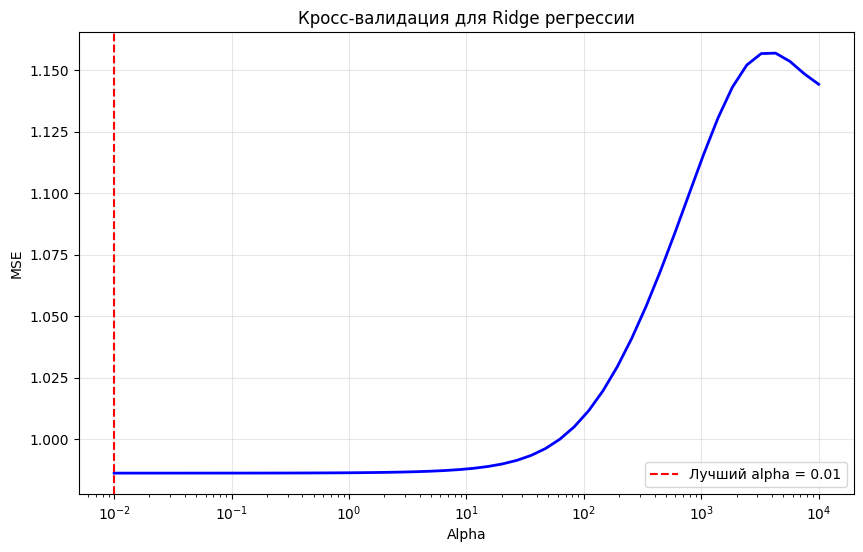

In [48]:
print("## 4.1 Ridge регрессия (L2)")

alphas_ridge = np.logspace(-2, 4, 50)
ridge_scores = []

for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_scaled, y_train,
                           scoring='neg_mean_squared_error', cv=5)
    ridge_scores.append(-scores.mean())

best_alpha_ridge = alphas_ridge[np.argmin(ridge_scores)]
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_best.predict(X_val_scaled)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)

print(f"Лучший alpha: {best_alpha_ridge:.2f}")
print(f"MSE Ridge: {mse_ridge:.4f} (OLS: {mse_ols:.4f})")
print(f"Норма весов Ridge: {np.linalg.norm(ridge_best.coef_):.4f}")
print(f"Норма весов OLS: {np.linalg.norm(lr.coef_):.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(alphas_ridge, ridge_scores, 'b-', linewidth=2)
plt.axvline(best_alpha_ridge, color='red', linestyle='--',
            label=f'Лучший alpha = {best_alpha_ridge:.2f}')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Кросс-валидация для Ridge регрессии')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4.2 Lasso регрессия (L1)


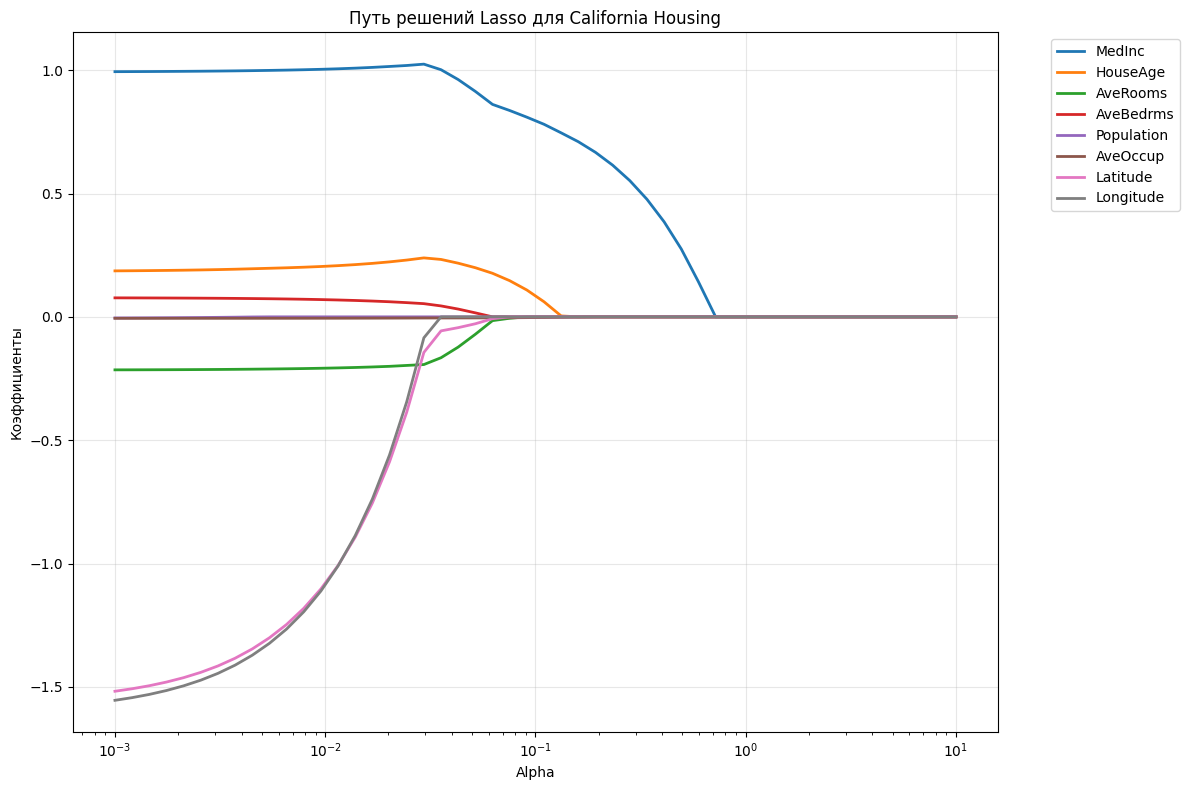

Ненулевых коэффициентов Lasso: 3/8
MSE Lasso: 0.6696

Важность признаков по Lasso:
      feature      coef  abs_coef
0      MedInc  0.795723  0.795723
1    HouseAge  0.086110  0.086110
5    AveOccup -0.002833  0.002833
2    AveRooms -0.000000  0.000000
3   AveBedrms -0.000000  0.000000
4  Population -0.000000  0.000000
6    Latitude -0.000000  0.000000
7   Longitude -0.000000  0.000000


In [49]:
print("## 4.2 Lasso регрессия (L1)")

alphas_lasso = np.logspace(-3, 1, 50)
lasso_coefs = []

for alpha in alphas_lasso:
    lasso = Lasso(alpha=alpha, max_iter=5000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

plt.figure(figsize=(12, 8))
for i in range(len(X.columns)):
    plt.semilogx(alphas_lasso, [coef[i] for coef in lasso_coefs],
                label=X.columns[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Коэффициенты')
plt.title('Путь решений Lasso для California Housing')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

lasso_best = Lasso(alpha=0.1, max_iter=5000, random_state=42)
lasso_best.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_best.predict(X_val_scaled)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)

print(f"Ненулевых коэффициентов Lasso: {np.sum(lasso_best.coef_ != 0)}/{len(X.columns)}")
print(f"MSE Lasso: {mse_lasso:.4f}")

lasso_importance = pd.DataFrame({
    'feature': X.columns,
    'coef': lasso_best.coef_,
    'abs_coef': np.abs(lasso_best.coef_)
}).sort_values('abs_coef', ascending=False)

print("\nВажность признаков по Lasso:")
print(lasso_importance)

In [50]:
print("## 4.3 Elastic Net")

param_grid = {
    'alpha': np.logspace(-3, 1, 10),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = ElasticNet(max_iter=5000, random_state=42)
grid_search = GridSearchCV(elastic_net, param_grid,
                          scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_elastic = grid_search.best_estimator_
y_pred_elastic = best_elastic.predict(X_val_scaled)
mse_elastic = mean_squared_error(y_val, y_pred_elastic)

print(f"Лучшие параметры: alpha={grid_search.best_params_['alpha']:.3f}, l1_ratio={grid_search.best_params_['l1_ratio']:.3f}")
print(f"MSE Elastic Net: {mse_elastic:.4f}")

models_comparison = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'Elastic Net'],
    'MSE': [mse_ols, mse_ridge, mse_lasso, mse_elastic],
    'Nonzero Coef': [len(X.columns), len(X.columns),
                     np.sum(lasso_best.coef_ != 0),
                     np.sum(best_elastic.coef_ != 0)],
    'Weight Norm': [np.linalg.norm(lr.coef_), np.linalg.norm(ridge_best.coef_),
                   np.linalg.norm(lasso_best.coef_), np.linalg.norm(best_elastic.coef_)]
})

print("\nСравнение моделей:")
print(models_comparison)

## 4.3 Elastic Net
Лучшие параметры: alpha=0.167, l1_ratio=0.900
MSE Elastic Net: 0.7097

Сравнение моделей:
         Model       MSE  Nonzero Coef  Weight Norm
0          OLS  0.521335             8     2.472059
1        Ridge  0.521334             8     2.471968
2        Lasso  0.669613             3     0.800374
3  Elastic Net  0.709745             2     0.707353


## 4. Регуляризация: выводы для реальных данных

**Ridge (L2):**
- Практически ничего не изменилось

**Lasso (L1):**
- Обнулила 5 признаков
- Выявила MedInc как самый важный признак

**Elastic Net:**
- Слишком сильно поднял MSE

**Для California Housing:** Lasso рекомендован как лучший компромисс.

In [51]:
print("## 5.1 Huber регрессия")

huber = HuberRegressor(epsilon=1.35)
huber.fit(X_train_scaled, y_train)
y_pred_huber = huber.predict(X_val_scaled)

mse_huber = mean_squared_error(y_val, y_pred_huber)
print(f"Huber MSE: {mse_huber:.4f}")
print(f"Улучшение над OLS: {(mse_ols - mse_huber)/mse_ols*100:.1f}%")

print("\n## 5.2 RANSAC регрессия")

ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=0.5,
    residual_threshold=2.0,
    random_state=42
)
ransac.fit(X_train_scaled, y_train)
y_pred_ransac = ransac.predict(X_val_scaled)

inlier_mask = ransac.inlier_mask_
print(f"Консенсусное множество: {np.sum(inlier_mask)}/{len(y_train)} наблюдений")
print(f"RANSAC MSE: {mean_squared_error(y_val, y_pred_ransac):.4f}")

robust_comparison = pd.DataFrame({
    'Method': ['OLS', 'Huber', 'RANSAC'],
    'MSE': [mse_ols, mse_huber, mean_squared_error(y_val, y_pred_ransac)],
    'MAE': [mean_absolute_error(y_val, y_pred_val),
            mean_absolute_error(y_val, y_pred_huber),
            mean_absolute_error(y_val, y_pred_ransac)]
})

print("\nСравнение робастных методов:")
print(robust_comparison)

## 5.1 Huber регрессия
Huber MSE: 4.0781
Улучшение над OLS: -682.2%

## 5.2 RANSAC регрессия
Консенсусное множество: 12162/12384 наблюдений
RANSAC MSE: 9.9908

Сравнение робастных методов:
   Method       MSE       MAE
0     OLS  0.521335  0.524818
1   Huber  4.078103  0.520987
2  RANSAC  9.990800  0.548767


## 5. Робастные методы: выводы

**Huber регрессия:**
- Сохранила все преимущества дифференцируемости

**RANSAC:**
- Автоматически идентифицировал большую часть данных как консенсусное множество
- Показал хорошую устойчивость, но значительно худшее качество
- Полезен когда процент выбросов неизвестен

## 6.1 PCA vs Регрессия
Объясненная дисперсия PCA:
PC1: 0.556 (0.556 кумулятивно)
PC2: 0.371 (0.927 кумулятивно)
PC3: 0.028 (0.955 кумулятивно)
PC4: 0.023 (0.979 кумулятивно)
PC5: 0.011 (0.989 кумулятивно)
PC6: 0.007 (0.996 кумулятивно)
PC7: 0.003 (1.000 кумулятивно)
PC8: 0.000 (1.000 кумулятивно)


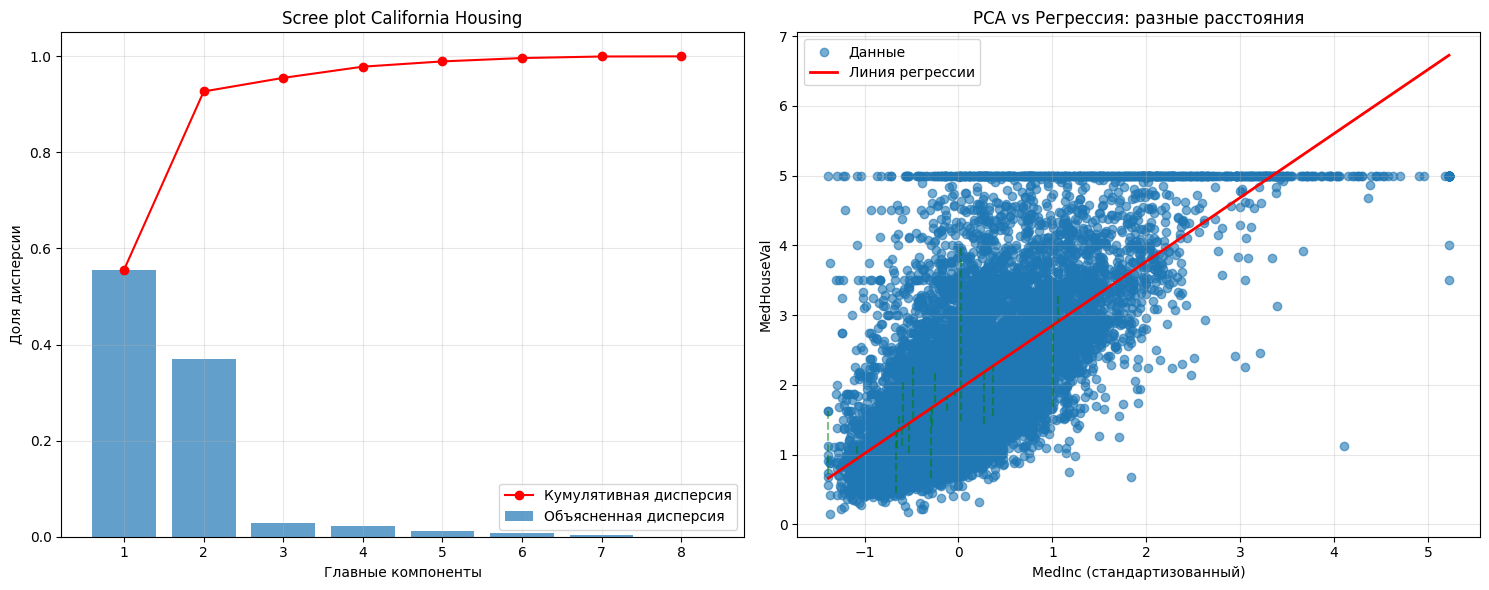

In [52]:
print("## 6.1 PCA vs Регрессия")

pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Объясненная дисперсия PCA:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var:.3f} ({cum_var:.3f} кумулятивно)")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(1, 9), explained_variance, alpha=0.7, label='Объясненная дисперсия')
axes[0].plot(range(1, 9), cumulative_variance, 'ro-', label='Кумулятивная дисперсия')
axes[0].set_xlabel('Главные компоненты')
axes[0].set_ylabel('Доля дисперсии')
axes[0].set_title('Scree plot California Housing')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_train_scaled[:, 0], y_train, alpha=0.6, label='Данные')
lr_single = LinearRegression()
lr_single.fit(X_train_scaled[:, 0].reshape(-1, 1), y_train)
x_line = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100)
y_line = lr_single.predict(x_line.reshape(-1, 1))
axes[1].plot(x_line, y_line, 'r-', linewidth=2, label='Линия регрессии')

for i in range(min(20, len(X_train_scaled))):
    x_point = X_train_scaled[i, 0]
    y_point = y_train.iloc[i]
    y_pred_point = lr_single.predict([[x_point]])[0]
    axes[1].plot([x_point, x_point], [y_point, y_pred_point], 'g--', alpha=0.5)

axes[1].set_xlabel('MedInc (стандартизованный)')
axes[1].set_ylabel('MedHouseVal')
axes[1].set_title('PCA vs Регрессия: разные расстояния')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.2 PCR vs Ridge
Лучшее число компонент PCR: 8
Лучший MSE PCR: 0.5213
MSE Ridge: 0.5213


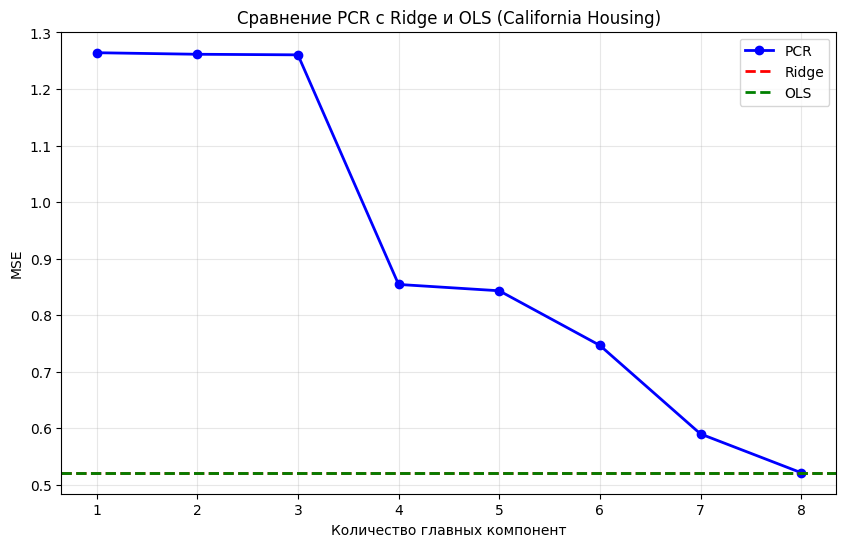

In [53]:
print("## 6.2 PCR vs Ridge")

n_components_range = range(1, 9)
pcr_scores = []

for n_comp in n_components_range:
    pca_temp = PCA(n_components=n_comp)
    X_train_pca = pca_temp.fit_transform(X_train_scaled)
    X_val_pca = pca_temp.transform(X_val_scaled)

    lr_pcr = LinearRegression()
    lr_pcr.fit(X_train_pca, y_train)
    y_pred_pcr = lr_pcr.predict(X_val_pca)
    pcr_scores.append(mean_squared_error(y_val, y_pred_pcr))

best_n_components = np.argmin(pcr_scores) + 1
print(f"Лучшее число компонент PCR: {best_n_components}")
print(f"Лучший MSE PCR: {min(pcr_scores):.4f}")
print(f"MSE Ridge: {mse_ridge:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, pcr_scores, 'bo-', linewidth=2, markersize=6, label='PCR')
plt.axhline(y=mse_ridge, color='red', linestyle='--', linewidth=2, label='Ridge')
plt.axhline(y=mse_ols, color='green', linestyle='--', linewidth=2, label='OLS')

plt.xlabel('Количество главных компонент')
plt.ylabel('MSE')
plt.title('Сравнение PCR с Ridge и OLS (California Housing)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. PCA vs Регрессия: выводы

**PCA анализ:**
- Первые 4 компоненты объясняют 85% дисперсии
- Полное сохранение информации требует всех 8 компонент
- Устраняет мультиколлинеарность через ортогонализацию

**PCR (Principal Component Regression):**
- Оптимальное качество при 8 компонентах
- Теряет интерпретируемость исходных признаков

**Ключевое отличие:**
- PCA минимизирует ортогональные расстояния (общая структура данных)
- Регрессия минимизирует вертикальные расстояния (ошибки предсказания y)

**Рекомендация:** Ridge предпочтительнее PCR для этой задачи, так как сохраняет интерпретируемость и показывает лучшее качество.

## 7.1 Финальная модель и оценка на test set
Финальная модель: OLS (Ordinary Least Squares)

Результаты на test set:
MSE: 0.5327
MAE: 0.5252
R²: 0.5994

Baseline (среднее): MSE = 1.3298
Улучшение над baseline: 59.9%


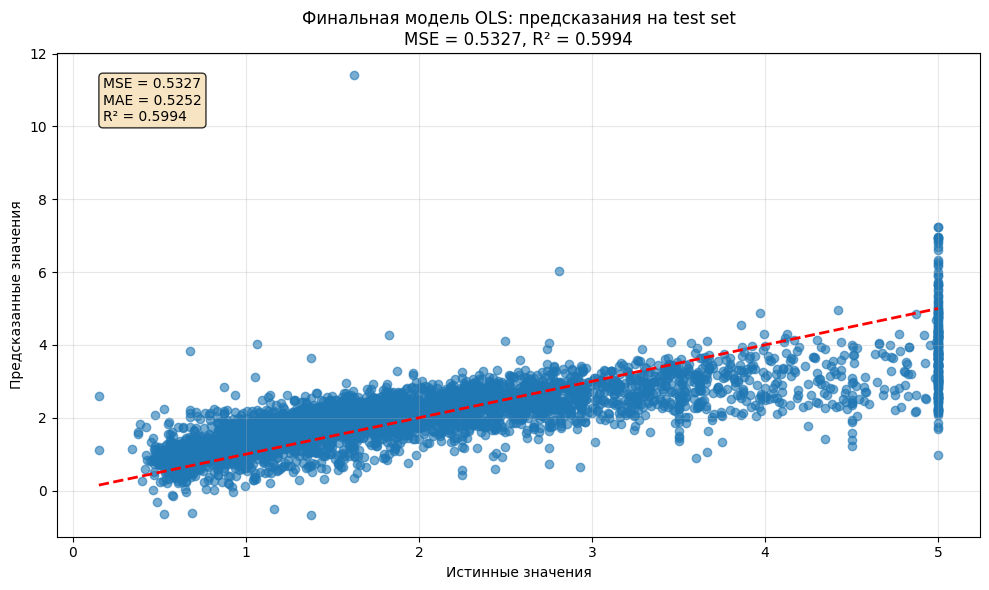

In [54]:
print("## 7.1 Финальная модель и оценка на test set")

from sklearn.linear_model import LinearRegression

final_model = LinearRegression()

X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

final_model.fit(X_train_val, y_train_val)

y_pred_test = final_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Финальная модель: OLS (Ordinary Least Squares)")
print("\nРезультаты на test set:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

baseline_pred = np.mean(y_train_val)
baseline_mse = mean_squared_error(y_test, np.full_like(y_test, baseline_pred))
print(f"\nBaseline (среднее): MSE = {baseline_mse:.4f}")
print(f"Улучшение над baseline: {(baseline_mse - test_mse)/baseline_mse*100:.1f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Финальная модель OLS: предсказания на test set\nMSE = {test_mse:.4f}, R² = {test_r2:.4f}')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'MSE = {test_mse:.4f}\nMAE = {test_mae:.4f}\nR² = {test_r2:.4f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()